<a href="https://colab.research.google.com/github/rayxuan2000/Project/blob/main/Stock_prediction_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prediction RNN

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. For this example, I will predict Apple's stock price 7 days in advance.

The particular network architecture I will employ for my RNN is a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

# Pytorch LSTM Stock Predictor

This is a Pytorch version of the original Keras LSTM Stock Predictor provided by [Super DataScience](https://www.superdatascience.com/deep-learning/), and also available elsewhere in this repo as a notebook.

## Step 1: Loading the data

First let's load in our time series - a history of around 140 days of Apple's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [168]:
# download the data
# !wget https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv

In [169]:
# !ls .

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [171]:
# Importing the training set
dataset = data = pd.read_csv('./all_stocks_5yr.csv')

# dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
# training_set = dataset_train.iloc[:, 1:2].values

In [172]:
dataset.head(10)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
5,2013-02-15,13.93,14.61,13.93,14.50,15628000,AAL
6,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL
7,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL
8,2013-02-21,13.62,13.95,12.90,13.37,11922100,AAL
9,2013-02-22,13.57,13.60,13.21,13.57,6071400,AAL


In [173]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [174]:
dataset['Name'].value_counts()

AAL     1259
NRG     1259
NOC     1259
NLSN    1259
NKE     1259
        ... 
DXC      215
BHGE     152
BHF      143
DWDP     109
APTV      44
Name: Name, Length: 505, dtype: int64

In [175]:
dataset[dataset['Name']=='SWKS']

,date,open,high,low,close,volume,Name
524591,2013-02-08,23.87,24.31,23.870,23.93,2522548,SWKS
524592,2013-02-11,23.87,24.34,23.730,24.25,2387664,SWKS
524593,2013-02-12,24.14,24.50,24.030,24.20,2991270,SWKS
524594,2013-02-13,24.21,24.50,24.060,24.30,2684874,SWKS
524595,2013-02-14,24.12,25.04,24.100,24.97,4413204,SWKS
...,...,...,...,...,...,...,...
525845,2018-02-01,98.54,103.91,98.500,103.15,5172360,SWKS
525846,2018-02-02,102.28,102.49,98.930,98.96,3767699,SWKS
525847,2018-02-05,97.95,99.72,94.331,94.68,5451830,SWKS
525848,2018-02-06,101.05,106.74,100.750,104.56,8628644,SWKS


In [176]:
dataset_cl = dataset[dataset['Name']=='SWKS'].close.values
dataset_cl

array([ 23.93,  24.25,  24.2 , ...,  94.68, 104.56, 101.35])

In [177]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

# scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)
dataset_cl

array([[0.03930131],
       [0.04262841],
       [0.04210855],
       ...,
       [0.77490123],
       [0.87762529],
       [0.84425036]])

## Step 2:  Cutting time series into sequences (Sliding Window)

Time series is a sequence of numbers that we can represent in general mathematically as

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}(p=1,2,...,P)$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 5 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

In [178]:
# Create a function to process the data into 7 day look back slices
# lb is window size
def processData(data, lb):
    X, y = [], [] # X is input vector, Y is output vector
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        y.append(data[(i + lb), 0])
    return np.array(X), np.array(y)

X, y = processData(dataset_cl, 7)

## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 4/5 of it), and validate on a later chunk (the last 1/5) as this simulates how we would predict *future* values of a time series.

In [179]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

1000
251
1000
251


In [180]:
# Reshaping
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

## Step 4:  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- Layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- Layer 2 uses a fully connected module with one unit
- The 'mean_squared_error' loss should be used

In [181]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super().__init__()
        # super(RNN, self).__init__()

        self.num_directions = bidirectional+1

        # LSTM module
        self.rnn = nn.LSTM(
            input_size = i_size,
            hidden_size = h_size,
            num_layers = n_layers,
            dropout = dropout,
            bidirectional = bidirectional
        )

        # Output layer
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)

        hidden_size = hidden_state[-1].size(-1)

        # Convert dimension of r_out (-1 denotes it depends on other parameters)
        r_out = r_out.view(-1, self.num_directions, hidden_size)

        outs = self.out(r_out)

        return outs, hidden_state

In [182]:
# Globals
INPUT_SIZE = 7 # 5？
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128
# Hyper parameters
learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [183]:
rnn

RNN(
  (rnn): LSTM(7, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [184]:
# """
# class StockDataset(Dataset):

#     def __init__(self, X_dataset, Y_dataset):

#         self.X_dataset = torch.from_numpy(X_dataset)
#         self.Y_dataset = torch.from_numpy(Y_dataset)

#     def __len__(self):
#         return np.shape(self.Y_dataset)[0]

#     def __getitem__(self, idx):

#         sample = {'Sequence': self.X_dataset[:,idx,:], "Target": self.Y_dataset[idx]}


#         return sample
# """

In [185]:
# Train_ds=StockDataset(X_train, y_train)

In [186]:
history = [] # save loss in each epoch
# .cuda() copies element to the GPU memory
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

# Use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

# training
for epoch in range(num_epochs):

    # Train mode
    rnn.train()

    output, _ = rnn(inputs_cuda, hidden_state)
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()   # back propagation
    optimiser.step()   # update the parameters

    if epoch % 20 == 0:
        # Convert train mode to evaluation mode (disable dropout)
        rnn.eval()

        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.1678522378206253, eval loss 0.5096462965011597
epoch 1, loss 0.14684134721755981
epoch 2, loss 0.1264338493347168
epoch 3, loss 0.10784260928630829
epoch 4, loss 0.09037944674491882
epoch 5, loss 0.07476665824651718
epoch 6, loss 0.06233867630362511
epoch 7, loss 0.05473560467362404
epoch 8, loss 0.05587223172187805
epoch 9, loss 0.06455650925636292
epoch 10, loss 0.06710314750671387
epoch 11, loss 0.06147024780511856
epoch 12, loss 0.05440935492515564
epoch 13, loss 0.04811093956232071
epoch 14, loss 0.04491011053323746
epoch 15, loss 0.04305803030729294
epoch 16, loss 0.0419447161257267
epoch 17, loss 0.040634676814079285
epoch 18, loss 0.03849497810006142
epoch 19, loss 0.03522656485438347
epoch 20, loss 0.030711965635418892, eval loss 0.05239185318350792
epoch 21, loss 0.025661515071988106
epoch 22, loss 0.0213769543915987
epoch 23, loss 0.01921035535633564
epoch 24, loss 0.02046179212629795
epoch 25, loss 0.0200116578489542
epoch 26, loss 0.015539580024778843
epoch

In [187]:
rnn.out.weight

Parameter containing:
tensor([[-0.0094, -0.1035, -0.0776, -0.0961,  0.0845,  0.0119,  0.0930, -0.1036,
          0.0931,  0.1118,  0.0688,  0.0911, -0.0136,  0.0660, -0.0719,  0.0978,
         -0.1135, -0.0683, -0.1126, -0.0913,  0.1113, -0.1049, -0.0989,  0.0011,
         -0.0503,  0.0674, -0.1036,  0.0150,  0.1051,  0.1130, -0.1079,  0.0057,
         -0.0003,  0.0994,  0.0619, -0.0978,  0.1195,  0.0437, -0.0240, -0.0709,
         -0.0757, -0.0661, -0.1120,  0.1191,  0.0973, -0.1160, -0.1059,  0.0930,
          0.0675,  0.0138,  0.0525, -0.0761,  0.0637,  0.0558, -0.0433, -0.0681,
          0.0464,  0.0649, -0.0963, -0.1142, -0.0348,  0.0600,  0.1231, -0.0471]],
       device='cuda:0', requires_grad=True)

In [188]:
for param in rnn.parameters():
    print(param.data)

tensor([[ 0.0492, -0.0314,  0.1496,  ...,  0.0601,  0.1460,  0.1405],
        [ 0.0942,  0.0504, -0.0766,  ..., -0.0039, -0.0776, -0.0406],
        [-0.0777, -0.0002,  0.1409,  ..., -0.0897,  0.0817,  0.0925],
        ...,
        [-0.0599, -0.0884, -0.0287,  ..., -0.0345,  0.0970,  0.0284],
        [-0.0566,  0.0511, -0.0718,  ..., -0.0227,  0.1143,  0.1833],
        [-0.0802,  0.0771, -0.0536,  ..., -0.0354, -0.0497,  0.0723]],
       device='cuda:0')
tensor([[-0.0827,  0.0077,  0.0654,  ..., -0.0433, -0.0218,  0.0736],
        [ 0.0304, -0.0086, -0.1169,  ..., -0.0446,  0.0915,  0.0333],
        [-0.0690,  0.0134,  0.0701,  ...,  0.0336, -0.0562,  0.0049],
        ...,
        [-0.0358,  0.0319,  0.0017,  ...,  0.1274, -0.0036, -0.0020],
        [ 0.1379, -0.1256,  0.0143,  ...,  0.0852, -0.1040,  0.0451],
        [ 0.1180, -0.1149,  0.0866,  ..., -0.0896,  0.0425, -0.0892]],
       device='cuda:0')
tensor([-1.0432e-01, -6.5726e-03, -1.1646e-01,  5.6107e-02, -6.6346e-02,
         8.

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

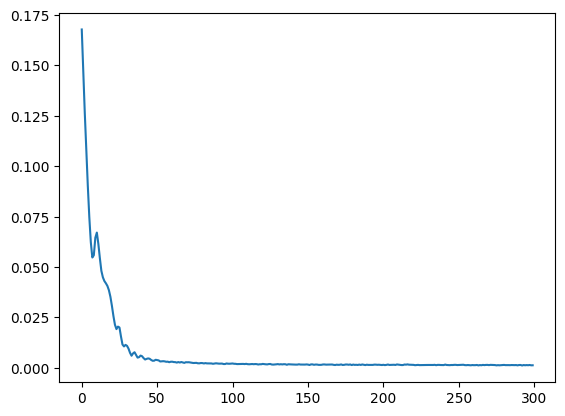

In [189]:
plt.plot(history)
# dplt.plot(history.history['val_loss'])

In [190]:
X_test[0]

array([[0.75733001, 0.74433354, 0.74433354, 0.73778332, 0.74246205,
        0.74069453, 0.74474943]])

In [191]:
# X_train_X_test = np.concatenate((X_train, X_test),axis=0)
# hidden_state = None
rnn.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [192]:
test_predict_cpu.shape

(251, 1, 1)

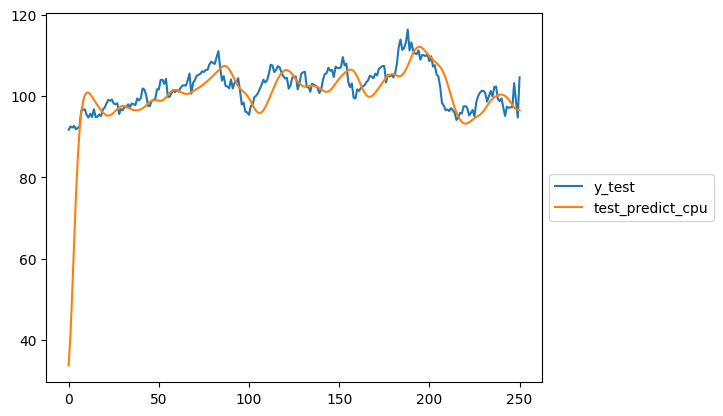

In [193]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))
plt.legend(['y_test','test_predict_cpu'], loc='center left', bbox_to_anchor=(1, 0.5))

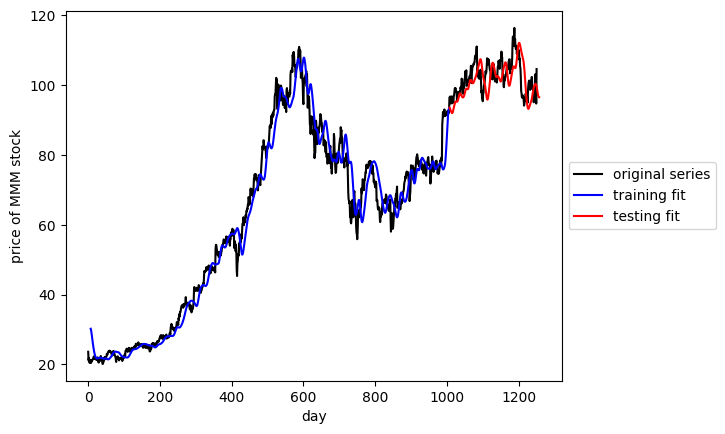

In [194]:
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of MMM stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [195]:
MMSE = (test_predict_cpu.reshape(1,X_test.shape[0])-y[1000:]).sum()/X_test.shape[0]
print(MMSE)

-0.011557202250578682
